# 5300 Final Project

Create classes to solve the double pendlum problem and the two-body problem for gravitational attraction.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## The Double Pendulum

The double pendulum we solve for here is a pendulum attached to the bob at the end of another pendulum. All the mass of each is located at the the bobs. We will use the formalism established in 11.4 of Classical Mecahnics by John R. Taylor:

Taylor, J. R. (2005). In Classical mechanics (pp. 430–436). University Science Books. 

### The Equation of Motion for a Double Pendulum
We start with Taylor equations (11.37) and (11.38):

$\begin{align}
  U = & (m_1 + m _2) g L_1 (1 - \cos \phi_1) + m_2 g L_2 (1-\cos \phi_2)
\end{align}$

$\begin{align}
   T = & \frac{1}{2} (m_1 + m _2) L_1^2 \dot \phi_1^2 + 
   m_2 L_1 L_2 \dot \phi_1 \dot \phi_2 \cos (\phi_1 - \phi_2)
   \frac{1}{2} m_2 L_2^2 \dot \phi_2^2
\end{align}$

We are going to use a Lagrangian approach to solve this problem. As such we nee to find the Lagrangian ($L = T - U$):

$\begin{align}
  L = & \frac{1}{2} (m_1 + m _2) L_1^2 \dot \phi_1^2 +
  m_2 L_1 L_2 \dot \phi_1 \dot \phi_2 \cos (\phi_1 - \phi_2) \\& +
  \frac{1}{2} m_2 L_2^2 \dot \phi_2^2 - (m_1 + m _2) g L_1 (1 - \cos \phi_1) \\& - m_2 g L_2 (1-\cos \phi_2)
\end{align}$

with $\phi_1$ and $\phi_2$ as our generalized coordinates.

We will also need to use the Euler-Lagrange equations:

$\begin{align}
    \frac{d}{dt} \left( \frac{\partial L}{\partial \dot q} \right) = 
     \frac{\partial L}{\partial q}
\end{align}$

for $q = \phi_1, \phi_2$ to find the equations of motion.

Applying E-L Equations we get the equations of motion for $\phi_1$ and $\phi_2$ to be:

$\begin{align}
    (m_1 + m _2) L_1 \ddot \phi_1  + m_2 L_2 \ddot \phi_2 \cos (\phi_1 - \phi2) =
    - m_2 L_2 \dot \phi_2^2 \sin (\phi_1 - \phi_2) - (m_1 + m_2) g \sin \phi_1
\end{align}$

$\begin{align}
    L_2 \ddot \phi_2 + L_1 \ddot \phi_1 \cos (\phi_1 - \phi_2) = 
    L_1 \dot \phi_1^2 \sin (\phi_1 - \phi_2) - g \sin (\phi_2)
\end{align}$

Dividing the first by $(m_1 + m_2) L_1$ and the second by \$L_2$ and going to matrix form:

$
\begin{align}
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}
\right)\begin{pmatrix}
        1 & \frac{m_2}{m_1 + m_2} \frac{L_2}{L_1} \cos (\phi_1 - \phi_2) \\
        \frac{L_1}{L_2} \cos (\phi_1 - \phi_2) & 1
        \end{pmatrix} =
        \left(\begin{array}{c}
         -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
         \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{array}\right)
\end{align}
$

Let's let:

$
\begin{align}
b = \frac{m_2}{m_1 + m_2} \frac{L_2}{L_1} \cos (\phi_1 - \phi_2)
\end{align}
$

$
\begin{align}
c = \frac{L_1}{L_2} \cos (\phi_1 - \phi_2)
\end{align}
$

Multiplying both sides by the inverse of the matrix on the left side:

$
\begin{align}
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}\right) = \frac{1}{1-bc}
        \begin{pmatrix}
        1 & -b \\
        -c & 1
        \end{pmatrix}
        \left(\begin{array}{c}
         -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
         \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{array}\right)
\end{align}
$

To again simplify the equtions, let:

$
\begin{align}
H = -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1
\end{align}
$

$
\begin{align}
D =  \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{align}
$

Finally, our equations of motion are:

$
\begin{align}
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}\right) = \frac{1}{1-bc}
        \left(\begin{array}{c}
         H - bD\\
         -cH + D
\end{array}\right)
\end{align}
$

### Pendulum class and utility functions
Using the equations of we found, we set up the ODE to be solved by integrate.solve_ivp, scipy's differential equation solver:

$\begin{align}
  \frac{d}{dt} \left(\begin{array}{c}
                     \phi_1 \\
                     \phi_2 \\
                     \dot \phi_1 \\
                     \dot \phi_2
               \end{array}\right) = 
                                    \left(\begin{array}{c}
                                          \dot \phi_1 \\
                                          \dot \phi_2 \\
                                          \frac{1}{1-bc} (H - bD) \\
                                          \frac{1}{1-bc} (-cH + D)
                                     \end{array}\right)
\end{align}
$

and we create a double pendulum class.

In [3]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and differential equation for 
     a double pendulum using the notation from Taylor.
     
    Parameters
    ----------
    m1 : float
        mass of mass 1 
    m2 : float
        mass of mass 2
    L1 : float
        length of pendulum 1
    L2 : float
        length of pendulum 2 
    g : float
        acceleration due to gravity 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m1, m2, L1, L2, g = 9.8):
        self.m1 = m1
        self.m2 = m2
        self.L1 = L1
        self.L2 = L2
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dphi2/dt d^2phi1/dt^2  d^2phi2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = phi_2(t), y[2] = dphi_1/dt, y[3] = dphi_2/dt             
        """
        b = self.m2 / (self.m1 + self.m2) * self.L2/self.L1 * np.cos(y[0]-y[1])
        c = self.L1 / self.L2 * np.cos(y[0] - y[1])
        prefactor = 1 / (1 - b * c)
        H = - self.m2 / (self.m1 + self.m2) * self.L2/self.L1 * y[3]**2 * np.sin(y[0] - y[1]) \
            -self.g/self.L1 * np.sin(y[0])
        D = self.L1/self.L2 * y[2]**2 * np.sin(y[0] - y[1]) - self.g/self.L2 * np.sin(y[1])
        return [y[2],y[3], prefactor * (H - b * D), prefactor * (-c * H + D)]
    
    def solve_ode(self, t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        We use solve.ivp and can specify abserr
        relerr for precision
        """
        y = [phi_1_0, phi_2_0, phi_dot_1_0, phi_dot_2_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_2, phi_dot_1, phi_dot_2 = solution.y

        return phi_1, phi_2, phi_dot_1, phi_dot_2

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

### Make plots for the double pendulum

We'll set it up with the specified parameters.

In [79]:
# Labels for individual plot axes
phi_1_vs_time_labels = (r'$t$', r'$\phi_1(t)$')
phi_2_vs_time_labels = (r'$t$', r'$\phi_2(t)$')

# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Pendulum parameters
L1 = 1.
L2 = 1.
m1 = 1.
m2 = 1.
g = 9.8

# Instantiate a double pendulum 
p1 = DoublePendulum(m1 = m1, m2 = m2, L1 = L1, L2 = L2, g = g)

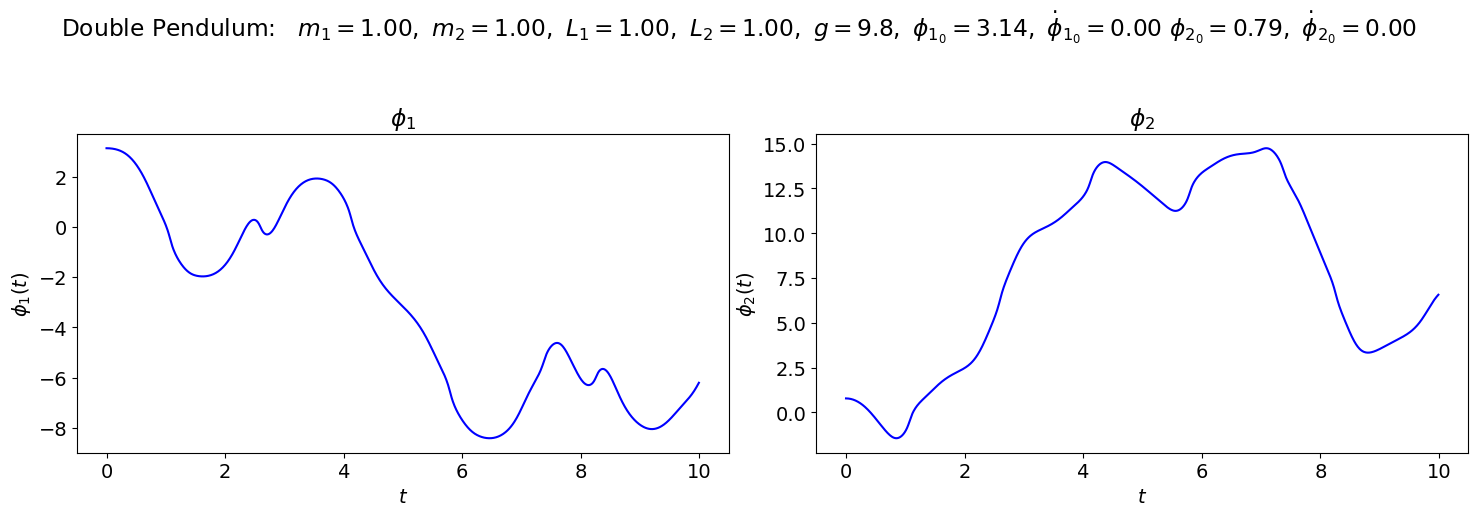

In [80]:
# initial conditions specified
phi_1_0 = np.pi
phi_dot_1_0 = 0.0
phi_2_0 = np.pi / 4.
phi_dot_2_0 = 0.0

# solve the pendulum
phi_1, phi_2, phi_dot_1, phi_dot_2 = p1.solve_ode(t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double Pendulum:  ' + \
                rf' $m_1 = {m1:.2f},$' + \
                rf' $m_2 = {m2:.2f},$' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$' + \
                rf' $g = {g:.1f},$' + \
                rf' $\phi_{{1_0}} = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_{{1_0}} = {phi_dot_1_0:.2f}$' + \
                rf' $\phi_{{2_0}} = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_{{2_0}} = {phi_dot_2_0:.2f}$'
fig.suptitle(overall_title, va='baseline')
    
# first plot: plot phi_1 from t=0 to t=10   
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_1_vs_time_labels, 
            color='blue',
            label=None, 
            title=rf'$\phi_1$', 
            ax=ax_a)    
                              
# second plot: plot  phi_2 from t=0 to t=10   
ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_2_vs_time_labels, 
            color='blue',
            label=None, 
            title=rf'$\phi_2$', 
            ax=ax_b)     

fig.tight_layout()

### Chaos Check
To show the system is chaotic, we make plots of $\Delta \phi$ for double pendulums of slightly different intial conditions for both $\phi_1$ and $\phi_2$ and see if they have a positive slope

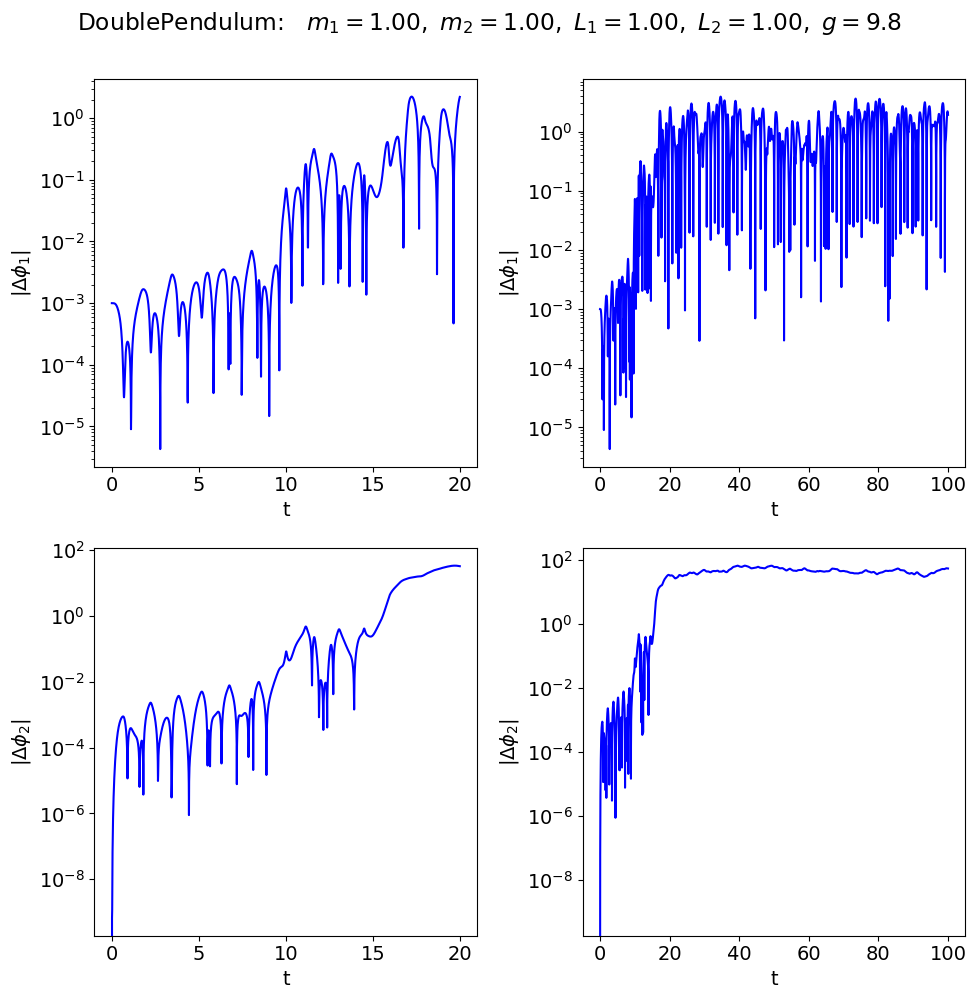

In [82]:
# Labels for individual plot axes
Delta_phi_1_vs_time_labels = (r'$t$', r'$\Delta\phi_1(t)$')
Delta_phi_2_vs_time_labels = (r'$t$', r'$\Delta\phi_2(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# make a plot of Delta phi for same double pendulum but two different initial conditions
phi_1i_0 = np.pi /2.
phi_dot_1i_0 = 0.0
phi_2i_0 = np.pi / 2.
phi_dot_2i_0 = 0.0
phi_1i, phi_2i, phi_dot_1i, phi_dot_2i = \
    p1.solve_ode(t_pts, phi_1i_0, phi_dot_1i_0, phi_2i_0, phi_dot_2i_0)

phi_1j_0 = np.pi/2. + 0.001 # 0.001 radians higher
phi_dot_1j_0 = 0.0
phi_2j_0 = np.pi / 2.
phi_dot_2j_0 = 0.0
phi_1j, phi_2j, phi_dot_1j, phi_dot_2j = \
    p1.solve_ode(t_pts, phi_1j_0, phi_dot_1j_0, phi_2j_0, phi_dot_2j_0)

# Calculate the absolute value of \phi_1j - \phi_1i
Delta_phi_1 = np.fabs(phi_1j - phi_1i)

# Calculate the absolute value of \phi_2j - \phi_2i
Delta_phi_2 = np.fabs(phi_2j - phi_2i)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = 'DoublePendulum:  ' + \
                rf' $m_1 = {m1:.2f},$' + \
                rf' $m_2 = {m2:.2f},$' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$' + \
                rf' $g = {g:.1f}$'
fig.suptitle(overall_title, va='baseline')

# Four plots: plot from t=0 to t=20 and another from t=0 to t=100 
#  for both phi_1 and phi_2
ax_a = fig.add_subplot(2,2,1)                  

start, stop = start_stop_indices(t_pts, 0.,20.)
ax_a.semilogy(t_pts[start : stop], Delta_phi_1[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi_1|$')

ax_b = fig.add_subplot(2,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_1[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\phi_1|$')

ax_c = fig.add_subplot(2,2,3)                  

start, stop = start_stop_indices(t_pts, 0., 20.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_c.set_xlabel('t')
ax_c.set_ylabel(r'$|\Delta\phi_2|$')

ax_d = fig.add_subplot(2,2,4)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_d.set_xlabel('t')
ax_d.set_ylabel(r'$|\Delta\phi_2|$')
                              
fig.tight_layout()

We see that there is a positive slope for both diagrams, suggesting a positive Liapunov exponent, indicating chaotic motion.

### Animating the Double Pendulum

All animation cells will need to be re-run after downloading from GitHub, as the file is too big to upload with animations loaded.

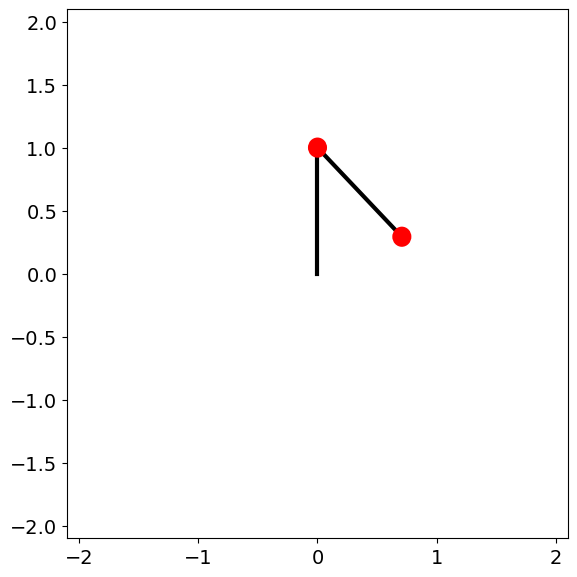

In [9]:
# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

# start a pendulum

# Pendulum parameters
L1 = 1.
L2 = 1.
m1 = 1.
m2 = 1.
g = 9.8

# Instantiate a double pendulum 
p2 = DoublePendulum(m1 = m1, m2 = m2, L1 = L1, L2 = L2, g = g)

# initial conditions specified
phi_1_0 = np.pi 
phi_dot_1_0 = 0.0
phi_2_0 = np.pi / 4.
phi_dot_2_0 = 0.0

# solve the pendulum
phi_1, phi_2, phi_dot_1, phi_dot_2 = p2.solve_ode(t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0)

    
#get x and y coordinates for any time
x_1, y_1 = L1 * np.sin(phi_1), -L1 * np.cos(phi_1)
x_2, y_2 = x_1 + L2 * np.sin(phi_2), y_1 - L2 * np.cos(phi_2)


#intial coordiantes
x_1_0, y_1_0 = L1 * np.sin(phi_1_0), -L1 * np.cos(phi_1_0)
x_2_0, y_2_0 = x_1_0 + L2 * np.sin(phi_2_0), y_1_0 - L2 * np.cos(phi_2_0)

#make intial pendulum massess and rods
fig = plt.figure(figsize=(6,6), num='Double Pendulum')
ax = fig.add_subplot(1,1,1)
gap = 0.1
ax.set_xlim(-(L1+L2)-gap, (L1+L2)+gap)
ax.set_ylim(-(L1+L2)-gap, (L1+L2)+gap)
line1, = ax.plot([0, x_1_0], [0, y_1_0], lw=3, c='k')
mass_radius = 0.08
circle1 = ax.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius,
                      fc='r', zorder=3))
line2, = ax.plot([x_1_0, x_2_0], [y_1_0, y_2_0], lw=3, c='k')
circle2 = ax.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius,
                      fc='r', zorder=3))
fig.tight_layout()

In [10]:
%%capture

fig_anim = plt.figure(figsize=(6,6), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
gap = 0.1
ax_anim.set_xlim(-(L1+L2)-gap, (L1+L2)+gap)
ax_anim.set_ylim(-(L1+L2)-gap, (L1+L2)+gap)

# By assigning the first return from plot all parts of the pendulum,
#  we can later change the values in the line.
line_anim1, = ax_anim.plot([0, x_1_0], [0, y_1_0], lw=3, c='k')
mass_radius = 0.08
circle_anim1 = ax_anim.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius,
                      fc='r', zorder=3))
line_anim2, = ax_anim.plot([x_1_0, x_2_0], [y_1_0, y_2_0], lw=3, c='k')
circle_anim2 = ax_anim.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius,
                      fc='r', zorder=3))

fig_anim.tight_layout()

In [11]:
def animate_pendulum(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    x_1_i, y_1_i = x_1[i], y_1[i]
    x_2_i, y_2_i = x_2[i], y_2[i]

    # overwrite lines and circles with new points
    line_anim1.set_data([0, x_1_i], [0, y_1_i])
    circle_anim1.set_center([x_1_i,y_1_i])
    line_anim2.set_data([x_1_i, x_2_i], [y_1_i, y_2_i])
    circle_anim2.set_center([x_2_i,y_2_i])
    
    return (line_anim1,circle_anim1,line_anim2, circle_anim2)   # this is needed for blit=True to work

In [12]:
frame_interval = 30.  # time between frames
frame_number = 800    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())

### Animating the Chaos Check

We can also see chaos by animating two double pendulums at once that start at slightly different intial conditions.

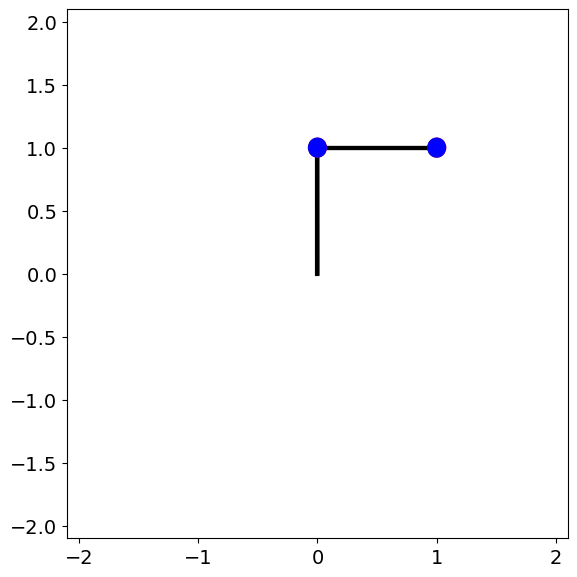

In [14]:
# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01


# Specify intial conditions
phi_1_0_a = np.pi 
phi_dot_1_0_a = 0.0
phi_2_0_a = np.pi / 2.
phi_dot_2_0_a = 0.0

phi_1_0_b = np.pi + 0.001 # differs by 0.001 radians
phi_dot_1_0_b = 0.0
phi_2_0_b = np.pi / 2.
phi_dot_2_0_b = 0.0

# Solve the pendulums; we use the p2 pendulum again

phi_1_a, phi_2_a, phi_dot_1_a, phi_dot_2_a = p2.solve_ode(t_pts, phi_1_0_a,
                                                          phi_dot_1_0_a, phi_2_0_a,
                                                          phi_dot_2_0_a)

phi_1_b, phi_2_b, phi_dot_1_b, phi_dot_2_b = p2.solve_ode(t_pts, phi_1_0_b,
                                                          phi_dot_1_0_b, phi_2_0_b,
                                                          phi_dot_2_0_b)

# Get x and y coordinates for all times
#  for each bob
x_1_a, y_1_a = L1 * np.sin(phi_1_a), -L1 * np.cos(phi_1_a)
x_2_a, y_2_a = x_1_a + L2 * np.sin(phi_2_a), y_1_a - L2 * np.cos(phi_2_a)

x_1_b, y_1_b = L1 * np.sin(phi_1_b), -L1 * np.cos(phi_1_b)
x_2_b, y_2_b = x_1_b + L2 * np.sin(phi_2_b), y_1_b - L2 * np.cos(phi_2_b)


#intial coordiantes
x_1_0_a, y_1_0_a = L1 * np.sin(phi_1_0_a), -L1 * np.cos(phi_1_0_a)
x_2_0_a, y_2_0_a = x_1_0_a + L2 * np.sin(phi_2_0_a), y_1_0_a - L2 * np.cos(phi_2_0_a)

x_1_0_b, y_1_0_b = L1 * np.sin(phi_1_0_b), -L1 * np.cos(phi_1_0_b)
x_2_0_b, y_2_0_b = x_1_0_b + L2 * np.sin(phi_2_0_b), y_1_0_b - L2 * np.cos(phi_2_0_b)

#make intial pendulum massess and rods
fig = plt.figure(figsize=(6,6), num='Double Pendulum Chaos')
ax = fig.add_subplot(1,1,1)
gap = 0.1
ax.set_xlim(-(L1+L2)-gap, (L1+L2)+gap)
ax.set_ylim(-(L1+L2)-gap, (L1+L2)+gap)

line1a, = ax.plot([0, x_1_0_a], [0, y_1_0_a], lw=3, c='k')

line1b, = ax.plot([0, x_1_0_b], [0, y_1_0_b], lw=3, c='k')


mass_radius = 0.08
circle1a = ax.add_patch(plt.Circle([x_1_0_a,y_1_0_a], mass_radius,
                      fc='r', zorder=3))
line2a, = ax.plot([x_1_0_a, x_2_0_a], [y_1_0_a, y_2_0_a], lw=3, c='k')
circle2a = ax.add_patch(plt.Circle([x_2_0_a,y_2_0_a], mass_radius,
                      fc='r', zorder=3))

circle1b = ax.add_patch(plt.Circle([x_1_0_b,y_1_0_b], mass_radius,
                      fc='b', zorder=3))
line2b, = ax.plot([x_1_0_b, x_2_0_b], [y_1_0_a, y_2_0_b], lw=3, c='k')
circle2b = ax.add_patch(plt.Circle([x_2_0_b,y_2_0_b], mass_radius,
                      fc='b', zorder=3))

fig.tight_layout()

In [15]:
%%capture

fig_anim = plt.figure(figsize=(6,6), num='Double Pendulum Chaos')
ax_anim = fig_anim.add_subplot(1,1,1)
gap = 0.1
ax_anim.set_xlim(-(L1+L2)-gap, (L1+L2)+gap)
ax_anim.set_ylim(-(L1+L2)-gap, (L1+L2)+gap)

# By assigning the first return from plot all parts of the pendulum
#, we can later change the values in the line.
line1a_anim, = ax_anim.plot([0, x_1_0_a], [0, y_1_0_a], lw=3, c='k')

line1b_anim, = ax_anim.plot([0, x_1_0_b], [0, y_1_0_b], lw=3, c='k')


mass_radius = 0.08
circle1a_anim = ax_anim.add_patch(plt.Circle([x_1_0_a,y_1_0_a], mass_radius,
                      fc='r', zorder=3))
line2a_anim, = ax_anim.plot([x_1_0_a, x_2_0_a], [y_1_0_a, y_2_0_a], lw=3, c='k')
circle2a_anim = ax_anim.add_patch(plt.Circle([x_2_0_a,y_2_0_a], mass_radius,
                      fc='r', zorder=3))

circle1b_anim = ax_anim.add_patch(plt.Circle([x_1_0_b,y_1_0_b], mass_radius,
                      fc='b', zorder=3))
line2b_anim, = ax_anim.plot([x_1_0_b, x_2_0_b], [y_1_0_a, y_2_0_b], lw=3, c='k')
circle2b_anim = ax_anim.add_patch(plt.Circle([x_2_0_b,y_2_0_b], mass_radius,
                      fc='b', zorder=3))

fig_anim.tight_layout()

In [16]:
def animate_pendulum_chaos(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    
    x_1_a_i, y_1_a_i = x_1_a[i], y_1_a[i]
    x_2_a_i, y_2_a_i = x_2_a[i], y_2_a[i]
    
    x_1_b_i, y_1_b_i = x_1_b[i], y_1_b[i]
    x_2_b_i, y_2_b_i = x_2_b[i], y_2_b[i]

    # overwrite lines and circles with new points
    line1a_anim.set_data([0, x_1_a_i], [0, y_1_a_i])
    circle1a_anim.set_center([x_1_a_i,y_1_a_i])
    line2a_anim.set_data([x_1_a_i, x_2_a_i], [y_1_a_i, y_2_a_i])
    circle2a_anim.set_center([x_2_a_i,y_2_a_i])
    
    line1b_anim.set_data([0, x_1_b_i], [0, y_1_b_i])
    circle1b_anim.set_center([x_1_b_i,y_1_b_i])
    line2b_anim.set_data([x_1_b_i, x_2_b_i], [y_1_b_i, y_2_b_i])
    circle2b_anim.set_center([x_2_b_i,y_2_b_i])
    
    return (line1a_anim,circle1a_anim,line2a_anim, circle2a_anim,
            line1b_anim,circle1b_anim,line2b_anim, circle2b_anim)   # this is needed for blit=True to work

In [17]:
frame_interval = 30.  # time between frames
frame_number = 800  # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum_chaos, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())

## Gravitational Orbits in Cartesian Coordinates
To plot these orbits, we first must find the equations of motion in Cartesian coordinates.

We start by writing down the Lagrangian for two mass $m_1$ and $m_2$ where the only potential is due to the gravitational attraction between them:

$\begin{align}
  U = & - \frac{G m_1 m_2}{\sqrt{(x_1 - x_2 )^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}}
\end{align}$

$\begin{align}
  T =& \frac{1}{2} m_1 (\dot x_1^2 + \dot y_1^2 + \dot z_1^2) + \frac{1}{2} m_2 (\dot x_2^2 + \dot y_2^2 + \dot z_2^2)
\end{align}$

$\begin{align}
  L = & \frac{1}{2} m_1 (\dot x_1^2 + \dot y_1^2 + \dot z_1^2) + \frac{1}{2} m_2 (\dot x_2^2 + \dot y_2^2 + 
  \dot z_2^2) \\ & + \frac{G m_1 m_2}{\sqrt{(x_1 - x_2 )^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}}
\end{align}$

Now we apply E-L equations for each coordinate. Note that there is a symmetry between the the x,y,and z coordinates. Let's focus on the x coodinate for both mass 1 and 2 for now.

For the x coordinates, E-L equations tell us:

$\begin{align}
  m_1 \ddot x_1 = \frac{-G m_1 m_2 (x_1 - x_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2)^\frac{3}{2}}
\end{align}$

$\begin{align}
  m_2 \ddot x_2 = \frac{G m_1 m_2 (x_1 - x_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2)^\frac{3}{2}}
\end{align}$

Moving to a matrix form and using the symmetry to get the other components and letting:

$\begin{align}
  B = \frac{G m_1 m_2}{((x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2)^\frac{3}{2}}
\end{align}$

We get:

$
\begin{align}
\left(\begin{array}{c}
         \ddot x_1 \\
         \ddot x_2 \\
         \ddot y_1 \\
         \ddot y_2 \\
         \ddot z_1 \\
         \ddot z_2
\end{array}\right) = B
        \left(\begin{array}{c}
         \frac{-(x_1-x_2)}{m_1}\\
         \frac{(x_1-x_2)}{m_2} \\
         \frac{-(y_1-y_2)}{m_1}\\
         \frac{(y_1-y_2)}{m_2} \\
         \frac{-(z_1-z_2)}{m_1} \\
         \frac{(z_1-z_2)}{m_2}
\end{array}\right)
\end{align}
$

for the equations of motion

## Orbit class and utility functions
Using the eqtion of motion we found, we set up the ODE to be solved by integrate.solve_ivp:

$\begin{align}
   \frac{d}{dt} \mathbf r = \frac{d}{dt} \left(\begin{array}{c}
                     x_1 \\
                     x_2 \\
                     y_1 \\
                     y_2 \\
                     z_1 \\
                     z_2 \\
                     \dot x_1 \\
                     \dot x_2 \\
                     \dot y_1 \\
                     \dot y_2 \\
                     \dot z_1 \\
                     \dot z_2
               \end{array}\right) = 
                                    \left(\begin{array}{c}
                                    \dot x_1 \\
                                    \dot x_2 \\
                                    \dot y_1 \\
                                    \dot y_2 \\
                                    \dot z_1 \\
                                    \dot z_2 \\
                                    \frac{-B(x_1-x_2)}{m_1} \\
                                    \frac{B(x_1-x_2)}{m_2} \\
                                    \frac{-B(y_1-y_2)}{m_1} \\
                                    \frac{B(y_1-y_2)}{m_2} \\
                                    \frac{-B(z_1-z_2)}{m_1} \\
                                    \frac{B(z_1-z_2)}{m_2}
                                     \end{array}\right)
\end{align}$

and we crete a class for the two-body orbits.

In [20]:
class CartesianOrbit():
    """
    CartesianOrbit class implements the parameters and differential equation for 
     the orbit of two bodies using Cartesian Coordinates.
     
    Parameters
    ----------
    m1 : float
        mass of body 1 
    m2 : float
        mass of body 2
    G : float
        gravitational constant

    Methods
    -------
    dr_dt(y, t)
        Returns the right side of the differential equation in vector r, 
        given time t and the corresponding value of r.
    """
    def __init__(self, m1, m2, G = 6.67 * (10**-11)):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    
    def dr_dt(self, t, r):
        """
        This function returns the right-hand side of the diffeq: 
        [dx_1/dt dx_2/dt ... d^2z_1/dt^2  d^2z_2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        r : float
            A 12-component vector with r[0] = x_1(t), r[1] = x_2(t), r[2] = y_1(t), r[3] = y_2(t)
            r[4] = z_1(t), r[5] = z_2(t), r[6] = dx_1/dt, ... , r[11] = dz_2/dt
        """
        B = self.G * self.m1 * self.m2 / ((r[0]-r[1])**2 + (r[2]-r[3])**2 + (r[4]-r[5])**2)**(3./2.)
        
        return [r[6],r[7],r[8],r[9],r[10],r[11], -(B/self.m1)*(r[0]-r[1]), (B/self.m2)*(r[0]-r[1]),
               -(B/self.m1)*(r[2]-r[3]), (B/self.m2)*(r[2]-r[3]),
                -(B/self.m1) * (r[4]-r[5]), (B/self.m2)*(r[4]-r[5])]
    
    def solve_ode(self, t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
             x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0, z_dot_2_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        Using solve.ivp
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
             x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0, z_dot_2_0] 
        solution = solve_ivp(self.dr_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2 = solution.y

        return x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2
    
    def energy(self, t_pts, x_1, x_2, y_1, y_2, z_1, z_2,
              x_1_dot, x_2_dot, y_1_dot, y_2_dot,
              z_1_dot, z_2_dot):
        """Evaluate the energy as a function of time. Needed for later"""
        K1 = 1./2. * self.m1 * (x_1_dot**2 + y_1_dot**2 + z_1_dot**2)
        K2 = 1./2. * self.m2 * (x_2_dot**2 + y_2_dot**2 + z_2_dot**2)
        U = (- self.G * self.m1 * self.m2 / 
              np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2 + (z_1 - z_2)**2))
        return K1 + K2 + U

### Make plots for the orbits

Let's allow only for orbits in the x-y plane. That is to say $z_{{1_0}} = z_{{2_0}} = \dot z_{{1_0}} = \dot z_{{2_0}} = 0$. The intial z coordinate of both masses can be done in this way without loss of generality, as we are free to rotate our axes until both masses are in the x-y plane. The masses will then stay coplaner due to conservation of angular momentum. 

In [212]:
y_vs_x_labels = (r'$x$', r'$y$')

# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters
m1 = 1.
m2 = 1.
G = 10. # We choose units such that G = 10

# Instantiate an orbit 
o1 = CartesianOrbit(m1 = m1, m2 = m2, G = G)

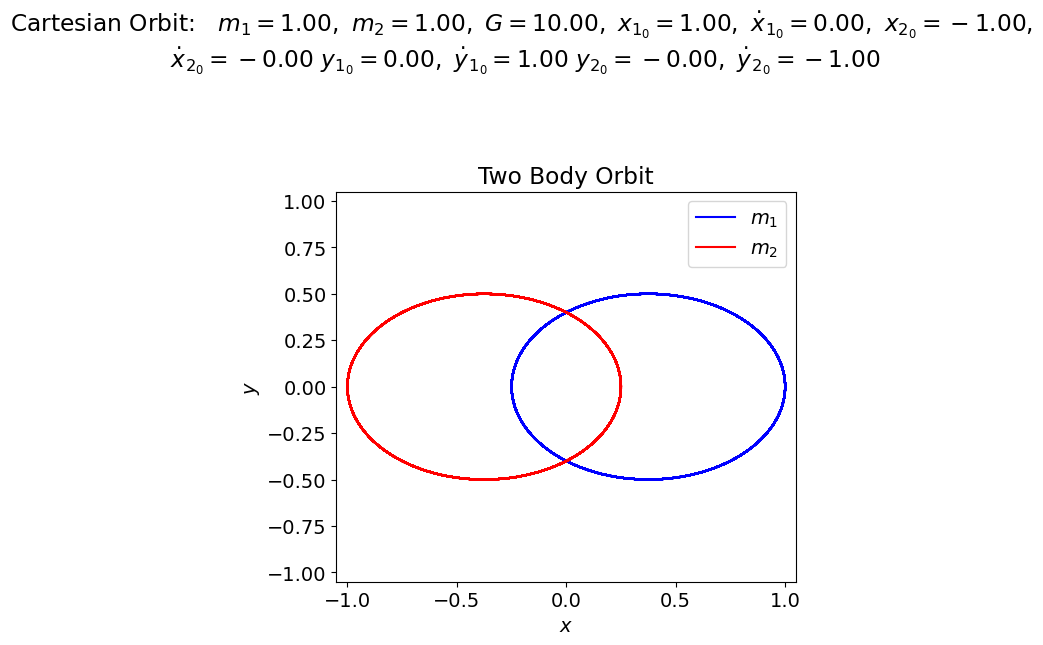

In [213]:
# initial conditions specified

# We choose intial conditions so that the center
#  of mass is stationary
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0, z_dot_1_0  = 0. ,0.
z_2_0, z_dot_2_0 = 0., 0.

# solve the orbit
(x_1, x_2, y_1, y_2, z_1, z_2,
 x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o1.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0,
                                           z_1_0, z_2_0, x_dot_1_0, x_dot_2_0,
                                           y_dot_1_0,y_dot_2_0, z_dot_1_0,
                                           z_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(6,6))
overall_title = 'Cartesian Orbit:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$' + \
                 rf' $x_{{1_0}} = {x_1_0:.2f},$' + \
                 rf' $\dot x_{{1_0}} = {x_dot_1_0:.2f},$' + \
                 rf' $x_{{2_0}} = {x_2_0:.2f},$' + '\n' + \
                 rf' $\dot x_{{2_0}} = {x_dot_2_0:.2f}$' + \
                 rf' $y_{{1_0}} = {y_1_0:.2f},$' + \
                 rf' $\dot y_{{1_0}} = {y_dot_1_0:.2f}$' + \
                 rf' $y_{{2_0}} = {y_2_0:.2f},$' + \
                 rf' $\dot y_{{2_0}} = {y_dot_2_0:.2f}$' 
fig.suptitle(overall_title, va='baseline')
    
# first plot: plot from t=0 to t=100  
ax_a = fig.add_subplot(1,1,1)                  

# Choosing plot limits to keep both masses on the plot
#  for the full orbit, and keeping the plot square
gap = 0.05
ax_a.set_xlim(min(x_2)-gap, max(x_1)+gap)
ax_a.set_ylim(min(x_2)-gap, max(x_1)+gap)

start, stop = start_stop_indices(t_pts, 0., 100.)    
plot_y_vs_x(x_1[start : stop], y_1[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='blue',
            label='$m_1$', 
            title=rf'', 
            ax=ax_a)
plot_y_vs_x(x_2[start : stop], y_2[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='red',
            label='$m_2$', 
            title=rf'Two Body Orbit',
            ax=ax_a)
ax_a.legend(loc = 'upper right')
fig.tight_layout()

### Now let's make $m_1 >> m_2$

We hope to see our orbits reduce to an elipse, hyperbola, or a parabola, with the heavy mass essentially at rest.

In [214]:
y_vs_x_labels = (r'$x$', r'$y$')

# Plotting time
t_start = 0.
t_end = 400.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters
m1 = 40.
m2 = 1.
G = 1000.

# Instantiate an orbit 
o2 = CartesianOrbit(m1 = m1, m2 = m2, G = G)

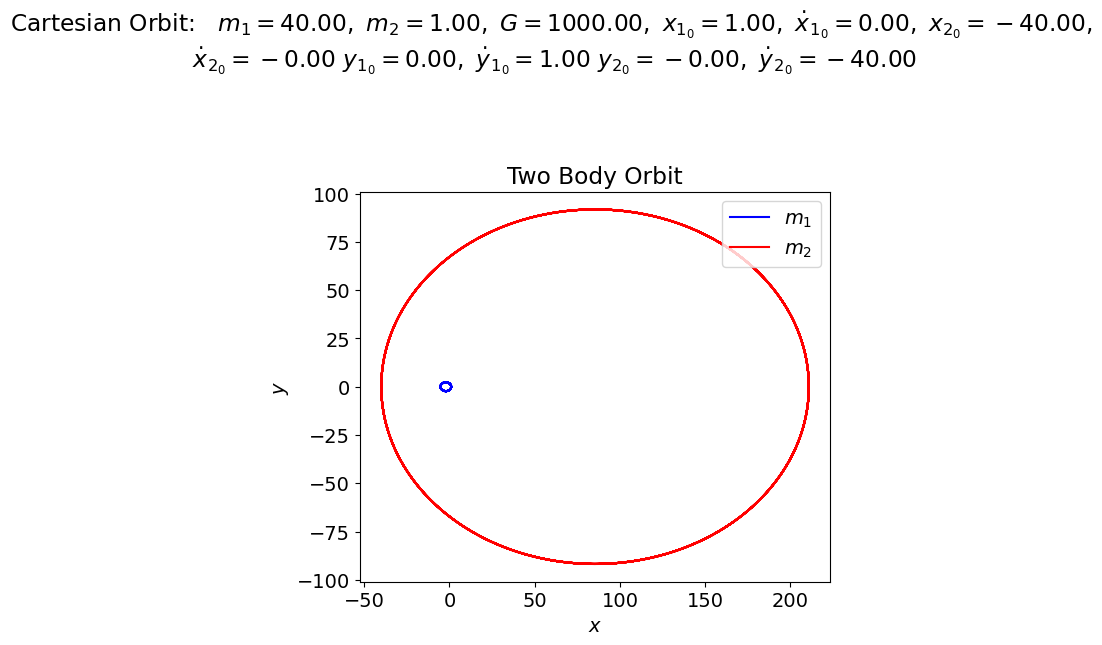

In [215]:
# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0, z_dot_1_0 = 0., 0.
z_2_0,z_dot_2_0 = 0., 0.

# solve the orbit
(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o2.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(6,6))
overall_title = 'Cartesian Orbit:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$' + \
                 rf' $x_{{1_0}} = {x_1_0:.2f},$' + \
                 rf' $\dot x_{{1_0}} = {x_dot_1_0:.2f},$' + \
                 rf' $x_{{2_0}} = {x_2_0:.2f},$' + '\n' + \
                 rf' $\dot x_{{2_0}} = {x_dot_2_0:.2f}$' + \
                 rf' $y_{{1_0}} = {y_1_0:.2f},$' + \
                 rf' $\dot y_{{1_0}} = {y_dot_1_0:.2f}$' + \
                 rf' $y_{{2_0}} = {y_2_0:.2f},$' + \
                 rf' $\dot y_{{2_0}} = {y_dot_2_0:.2f}$' 
fig.suptitle(overall_title, va='baseline')
    
#plot from t=0 to t=200  
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 400.)    
plot_y_vs_x(x_1[start : stop], y_1[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='blue',
            label='$m_1$', 
            title=rf'', 
            ax=ax_a)
plot_y_vs_x(x_2[start : stop], y_2[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='red',
            label='$m_2$', 
            title=rf'Two Body Orbit',
            ax=ax_a)
ax_a.legend(loc = 'upper right')
fig.tight_layout()

### Animating the Two-Body Orbit ($m_1 = m_2$)

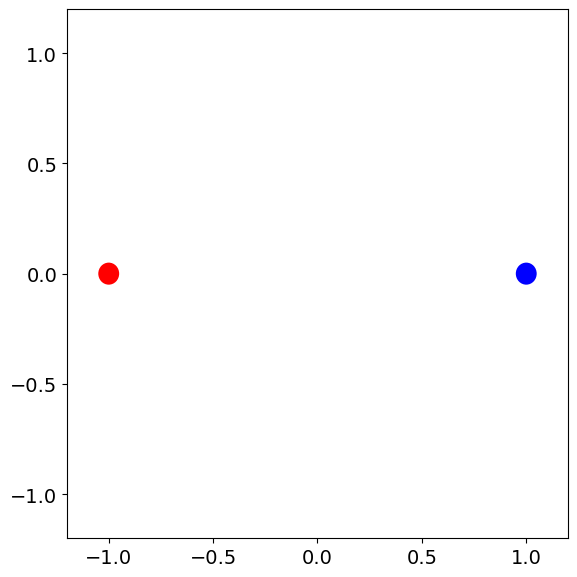

In [28]:
# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters and intial conditions
m1 = 1.
m2 = 1.
G = 10.

x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0 = 0.0
z_dot_1_0 = 0.0
z_2_0 = 0.0
z_dot_2_0 = 0.0

# solve the orbit
(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o1.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

# Make the inital bodies
x_1_0, y_1_0 = x_1[0], y_1[0]
x_2_0, y_2_0 = x_2[0], y_2[0]

fig = plt.figure(figsize=(6,6), num='Two-Body Orbit')
ax = fig.add_subplot(1,1,1)
gap = 0.2
ax.set_xlim(min(x_2)-gap, max(x_1)+gap)
ax.set_ylim(min(x_2)-gap, max(x_1)+gap)
mass_radius1 = 0.05
mass_radius2 = 0.05
circle1 = ax.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius1,
                      fc='b', zorder=3))
circle2 = ax.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius2,
                      fc='r', zorder=3))
fig.tight_layout()

In [29]:
%%capture

fig_anim = plt.figure(figsize=(6,6), num='Two-Body Orbit')
ax_anim = fig_anim.add_subplot(1,1,1)
# Choosing plot limits to keep both masses on the plot
#  for the full orbit, and keeping the plot square
gap = 0.2
ax_anim.set_xlim(min(x_2)-gap, max(x_1)+gap)
ax_anim.set_ylim(min(x_2)-gap, max(x_1)+gap)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
mass_radius1 = 0.05
mass_radius2 = 0.05
circle_anim1 = ax_anim.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius1,
                      fc='b', zorder=3))
circle_anim2 = ax_anim.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius2,
                      fc='r', zorder=3))

fig_anim.tight_layout()

In [30]:
def animate_orbit_equal(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    x_1_i, y_1_i = x_1[i], y_1[i]
    x_2_i, y_2_i = x_2[i], y_2[i]

    # overwrite lines and circles with new points
    circle_anim1.set_center([x_1_i,y_1_i])
    circle_anim2.set_center([x_2_i,y_2_i])
    
    return (circle_anim1, circle_anim2)   # this is needed for blit=True to work

In [31]:
frame_interval = 30.  # time between frames
frame_number = 750  # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_orbit_equal, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())

### Animating the Two-Body Orbit ($m_1 >> m_2$)

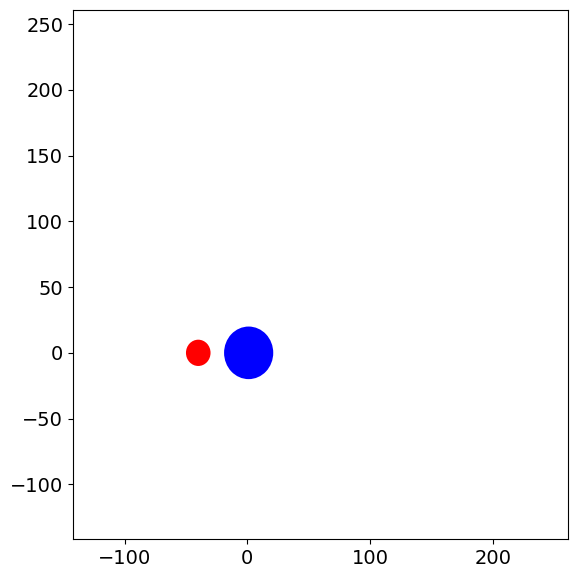

In [170]:
# Choosing parameters
m1 = 40.
m2 = 1.
G = 1000.

# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0 = 0.0
z_dot_1_0 = 0.0
z_2_0 = 0.0
z_dot_2_0 = 0.0

t_start = 0.
t_end = 513.
delta_t = 1.

t_pts = np.arange(t_start, t_end+delta_t, delta_t)


(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o2.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)


#make intial bodies
x_1_0, y_1_0 = x_1[0], y_1[0]
x_2_0, y_2_0 = x_2[0], y_2[0]

fig = plt.figure(figsize=(6,6), num='Two-Body Orbit')
ax = fig.add_subplot(1,1,1)

# Choosing plot limits to keep both masses on the plot
#  for the full orbit, and keeping the plot square
gap = 50
ax.set_xlim(min(y_2)-gap, max(x_2)+gap)
ax.set_ylim(min(y_2)-gap, max(x_2)+gap)
mass_radius1 = 20
mass_radius2 = 10
circle1 = ax.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius1,
                      fc='b', zorder=3))
circle2 = ax.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius2,
                      fc='r', zorder=3))
fig.tight_layout()

In [171]:
%%capture

fig_anim = plt.figure(figsize=(6,6), num='Two-Body Orbit')
ax_anim = fig_anim.add_subplot(1,1,1)
gap = 50
ax_anim.set_xlim(min(y_2)-gap, max(x_2)+gap)
ax_anim.set_ylim(min(y_2)-gap, max(x_2)+gap)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
mass_radius1 = 20
mass_radius2 = 10
circle_anim1 = ax_anim.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius1,
                      fc='b', zorder=3))
circle_anim2 = ax_anim.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius2,
                      fc='r', zorder=3))

fig_anim.tight_layout()

In [172]:
def animate_orbit(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    x_1_i, y_1_i = x_1[i], y_1[i]
    x_2_i, y_2_i = x_2[i], y_2[i]

    # overwrite lines and circles with new points
    circle_anim1.set_center([x_1_i,y_1_i])
    circle_anim2.set_center([x_2_i,y_2_i])
    
    return (circle_anim1, circle_anim2)   # this is needed for blit=True to work

In [173]:
frame_interval = 30.  # time between frames
frame_number = 416  # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_orbit, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())

### Leapfrog Method for Two-Body Orbit

The issue with the above is that it uses an ode solver to solve the orbits. This does not conserve energy in the orbit and thus is not wholly physical. We instead turn to the leap frog method to solve the orbits.

Let's let u be a general coordinate. This could be the x,y,or z coordinate.

$\begin{align}
\mathbf r = \left(\begin{array}{c}
                     x_1 \\
                     x_2 \\
                     y_1 \\
                     y_2 \\
                     z_1 \\
                     z_2 \\
                     \dot x_1 \\
                     \dot x_2 \\
                     \dot y_1 \\
                     \dot y_2 \\
                     \dot z_1 \\
                     \dot z_2
               \end{array}\right)
\end{align}
$

The leapfrog method does better by evaluating $\dot u$ at a halfway time step before and after the $u$ evaluation, 
which is both more accurate and incorporates time reversal. Lets show how this works for $x_1$ and $y_1$, but this holds for all coordinates:

$\begin{align}
   \dot x_{{1_{i+1/2}}} &= \dot x_{{1_i}} + \frac{d\mathbf{r}_{1_i}[6]}{dt}  \Delta t/2 \\
   x_{{1_{i+1}}} &= x_{1_i} +  \dot x_{{1_{i+1/2}}}  \Delta t  \\
   \dot x_{{1_{i+1}}} &= \dot x_{i+1/2} + \frac{d\mathbf{r}_{i+1}[6]}{dt}  \Delta t/2 \\
   \dot y_{{1_{i+1/2}}} &= \dot y_{{1_i}} + \frac{d\mathbf{r}_{1_i}[8]}{dt}  \Delta t/2 \\
   y_{{1_{i+1}}} &= y_{1_i} +  \dot y_{{1_{i+1/2}}}  \Delta t  \\
   \dot y_{{1_{i+1}}} &= \dot y_{i+1/2} + \frac{d\mathbf{r}_{i+1}[8]}{dt}  \Delta t/2 \\
\end{align}$

Let's recreate our CartesianOrbit class using this solver:

In [45]:
class CartesianOrbitLeapfrog():
    """
    CartesianOrbitLeapfrog class implements the parameters and differential equation for 
     the orbit of two bodies using Cartesian Coordinates. Uses the Leapfrog Method to solve
     
    Parameters
    ----------
    m1 : float
        mass of body 1 
    m2 : float
        mass of body 2
    G : float
        gravitational constant

    Methods
    -------
    dr_dt(y, t)
        Returns the right side of the differential equation in vector r, 
        given time t and the corresponding value of r.
    """
    def __init__(self, m1, m2, G = 6.67 * (10**-11)):
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dr_dt(self, t, r):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt dx2/dt ... d^2z1/dt^2  d^2z2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        r : float
            A 12-component vector with r[0] = x_1(t), r[1] = x_2(t), r[2] = y_1(t), r[3] = y_2(t)
            r[4] = z_1(t), r[5] = z_2(t), r[6] = dx_1/dt, ... , r[11] = dz_2/dt
        """
        B = self.G * self.m1 * self.m2 / ((r[0]-r[1])**2 + (r[2]-r[3])**2 + (r[4]-r[5])**2)**(3./2.)
        
        return [r[6],r[7],r[8],r[9],r[10],r[11], -(B/self.m1)*(r[0]-r[1]), (B/self.m2)*(r[0]-r[1]),
               -(B/self.m1)*(r[2]-r[3]), (B/self.m2)*(r[2]-r[3]),
                -(B/self.m1) * (r[4]-r[5]), (B/self.m2)*(r[4]-r[5])]
    
    def solve_ode_Leapfrog(self, t_pts,x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
             x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0, z_dot_2_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for all coordinates and velocities with zeros length of t_pts
        num_t_pts = len(t_pts)
        x_1 = np.zeros(num_t_pts)
        x_2 = np.zeros(num_t_pts)
        y_1 = np.zeros(num_t_pts)
        y_2 = np.zeros(num_t_pts)
        z_1 = np.zeros(num_t_pts)
        z_2 = np.zeros(num_t_pts)
        x_1_dot = np.zeros(num_t_pts)
        x_2_dot = np.zeros(num_t_pts)
        y_1_dot = np.zeros(num_t_pts)
        y_2_dot = np.zeros(num_t_pts)
        z_1_dot = np.zeros(num_t_pts)
        z_2_dot = np.zeros(num_t_pts)
        x_1_dot_half = np.zeros(num_t_pts)
        x_2_dot_half = np.zeros(num_t_pts)
        y_1_dot_half = np.zeros(num_t_pts)
        y_2_dot_half = np.zeros(num_t_pts)
        z_1_dot_half = np.zeros(num_t_pts)
        z_2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x_1[0] = x_1_0
        x_2[0] = x_2_0
        y_1[0] = y_1_0
        y_2[0] = y_2_0
        z_1[0] = z_1_0
        z_2[0] = z_2_0
        x_1_dot[0] = x_dot_1_0
        x_2_dot[0] = x_dot_2_0
        y_1_dot[0] = y_dot_1_0
        y_2_dot[0] = y_dot_2_0
        z_1_dot[0] = z_dot_1_0
        z_2_dot[0] = z_dot_2_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            r = [x_1[i], x_2[i], y_1[i], y_2[i], z_1[i], z_2[i],
                 x_1_dot[i], x_2_dot[i], y_1_dot[i], y_2_dot[i],
                 z_1_dot[i], z_2_dot[i]]
            
            x_1_dot_half[i] = x_1_dot[i] + self.dr_dt(t,r)[6] * delta_t/2.
            x_1[i+1] = x_1[i] + x_1_dot_half[i] * delta_t

            x_2_dot_half[i] = x_2_dot[i] + self.dr_dt(t,r)[7] * delta_t/2.
            x_2[i+1] = x_2[i] + x_2_dot_half[i] * delta_t
            
            y_1_dot_half[i] = y_1_dot[i] + self.dr_dt(t,r)[8] * delta_t/2.
            y_1[i+1] = y_1[i] + y_1_dot_half[i] * delta_t

            y_2_dot_half[i] = y_2_dot[i] + self.dr_dt(t,r)[9] * delta_t/2.
            y_2[i+1] = y_2[i] + y_2_dot_half[i] * delta_t
            
            z_1_dot_half[i] = z_1_dot[i] + self.dr_dt(t,r)[10] * delta_t/2.
            z_1[i+1] = z_1[i] + z_1_dot_half[i] * delta_t

            z_2_dot_half[i] = z_2_dot[i] + self.dr_dt(t,r)[11] * delta_t/2.
            z_2[i+1] = z_2[i] + z_2_dot_half[i] * delta_t
            
            r = [x_1[i+1], x_2[i+1], y_1[i+1], y_2[i+1], z_1[i+1], z_2[i+1],
                x_1_dot[i], x_2_dot[i], y_1_dot[i], y_2_dot[i],
                 z_1_dot[i], z_2_dot[i]]
            x_1_dot[i+1] = x_1_dot_half[i] + self.dr_dt(t, r)[6] * delta_t/2.
            x_2_dot[i+1] = x_2_dot_half[i] + self.dr_dt(t, r)[7] * delta_t/2.
            y_1_dot[i+1] = y_1_dot_half[i] + self.dr_dt(t, r)[8] * delta_t/2.
            y_2_dot[i+1] = y_2_dot_half[i] + self.dr_dt(t, r)[9] * delta_t/2.
            z_1_dot[i+1] = z_1_dot_half[i] + self.dr_dt(t, r)[10] * delta_t/2.
            z_2_dot[i+1] = z_2_dot_half[i] + self.dr_dt(t, r)[11] * delta_t/2.
        return (x_1, x_2, y_1, y_2, z_1, z_2,
                x_1_dot, x_2_dot, y_1_dot, y_2_dot,
                 z_1_dot, z_2_dot)
    
    def energy(self, t_pts, x_1, x_2, y_1, y_2, z_1, z_2,
              x_1_dot, x_2_dot, y_1_dot, y_2_dot,
              z_1_dot, z_2_dot):
        """Evaluate the energy as a function of time. Needed for later"""
        K1 = 1./2. * self.m1 * (x_1_dot**2 + y_1_dot**2 + z_1_dot**2)
        K2 = 1./2. * self.m2 * (x_2_dot**2 + y_2_dot**2 + z_2_dot**2)
        U = (- self.G * self.m1 * self.m2 / 
              np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2 + (z_1 - z_2)**2))
        return K1 + K2 + U

### Now let's solve the $m_1 = m_2$ orbit again

In [218]:
y_vs_x_labels = (r'$x$', r'$y$')

# Plotting time
t_start = 0.
t_end = 200.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters
m1 = 1.
m2 = 1.
G = 10.

# Instantiate an orbit 
o3 = CartesianOrbitLeapfrog(m1 = m1, m2 = m2, G = G)

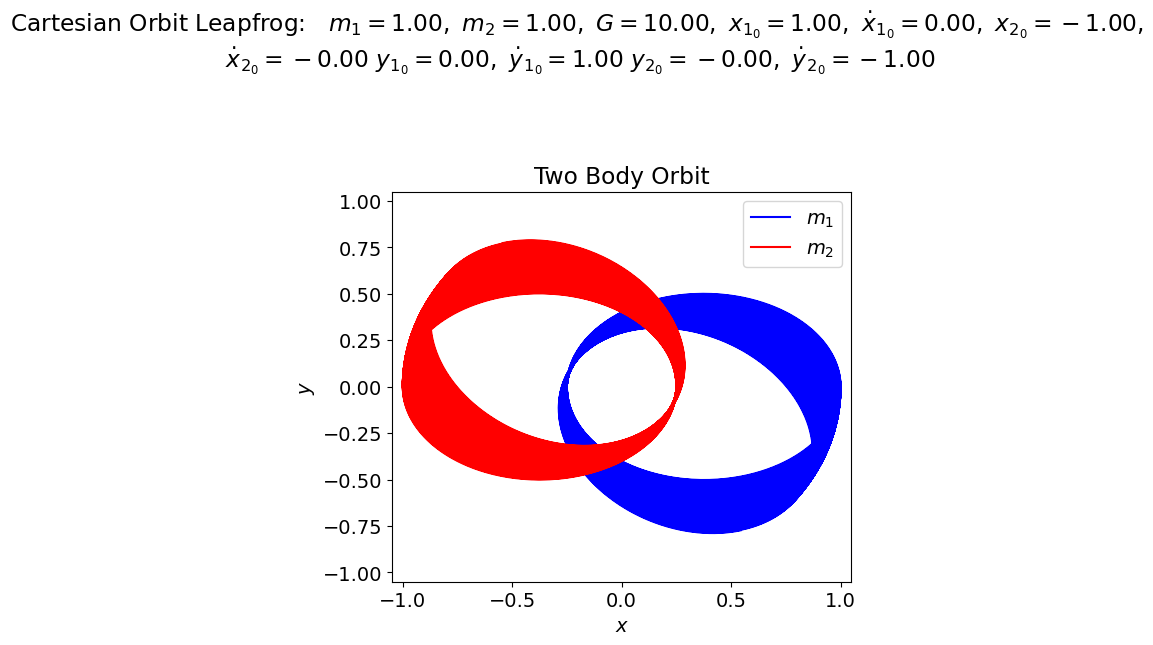

In [220]:
# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0, z_1_0_dot = 0., 0.
z_2_0, z_2_0_dot = 0., 0.

# solve the orbit
(x_1_LF, x_2_LF, y_1_LF, y_2_LF, z_1_LF, z_2_LF,
 x_dot_1_LF, x_dot_2_LF, y_dot_1_LF,
 y_dot_2_LF, z_dot_1_LF, z_dot_2_LF) = o3.solve_ode_Leapfrog(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(6,6))
overall_title = 'Cartesian Orbit Leapfrog:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$' + \
                 rf' $x_{{1_0}} = {x_1_0:.2f},$' + \
                 rf' $\dot x_{{1_0}} = {x_dot_1_0:.2f},$' + \
                 rf' $x_{{2_0}} = {x_2_0:.2f},$' + '\n' + \
                 rf' $\dot x_{{2_0}} = {x_dot_2_0:.2f}$' + \
                 rf' $y_{{1_0}} = {y_1_0:.2f},$' + \
                 rf' $\dot y_{{1_0}} = {y_dot_1_0:.2f}$' + \
                 rf' $y_{{2_0}} = {y_2_0:.2f},$' + \
                 rf' $\dot y_{{2_0}} = {y_dot_2_0:.2f}$' 
# #                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
#plot from t=0 to t=200  
ax_a = fig.add_subplot(1,1,1)

# Choosing plot limits to keep both masses on the plot
#  for the full orbit, and keeping the plot square
gap = 0.05
ax_a.set_xlim(min(x_2_LF)-gap, max(x_1_LF)+gap)
ax_a.set_ylim(min(x_2_LF)-gap, max(x_1_LF)+gap)

start, stop = start_stop_indices(t_pts, 0., 200.)    
plot_y_vs_x(x_1_LF[start : stop], y_1_LF[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='blue',
            label='$m_1$', 
            title=rf'', 
            ax=ax_a)
plot_y_vs_x(x_2_LF[start : stop], y_2_LF[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='red',
            label='$m_2$', 
            title=rf'Two Body Orbit',
            ax=ax_a)
ax_a.legend(loc = 'upper right')
fig.tight_layout()

 ### Energy Conservation ($m_1 = m_2$)

In [202]:
# Plotting time
t_start = 0.
t_end = 200.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Solving the orbits again to prevent issue with variable
# overloading

# Choosing parameters
m1 = 1.
m2 = 1.
G = 10.

# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0, z_1_0_dot = 0., 0.
z_2_0, z_2_0_dot = 0., 0.

(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o1.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)
(x_1_LF, x_2_LF, y_1_LF, y_2_LF, z_1_LF, z_2_LF,
 x_dot_1_LF, x_dot_2_LF, y_dot_1_LF,
 y_dot_2_LF, z_dot_1_LF, z_dot_2_LF) = o3.solve_ode_Leapfrog(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)


E_tot_pts = o1.energy(t_pts, x_1, x_2, y_1, y_2,
                      z_1, z_2, x_dot_1, x_dot_2,
                      y_dot_1, y_dot_2, z_dot_1,
                      z_dot_2)


E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)


E_tot_pts_LF = o3.energy(t_pts, x_1_LF, x_2_LF, y_1_LF, y_2_LF,
                      z_1_LF, z_2_LF, x_dot_1_LF, x_dot_2_LF,
                      y_dot_1_LF, y_dot_2_LF, z_dot_1_LF,
                      z_dot_2_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

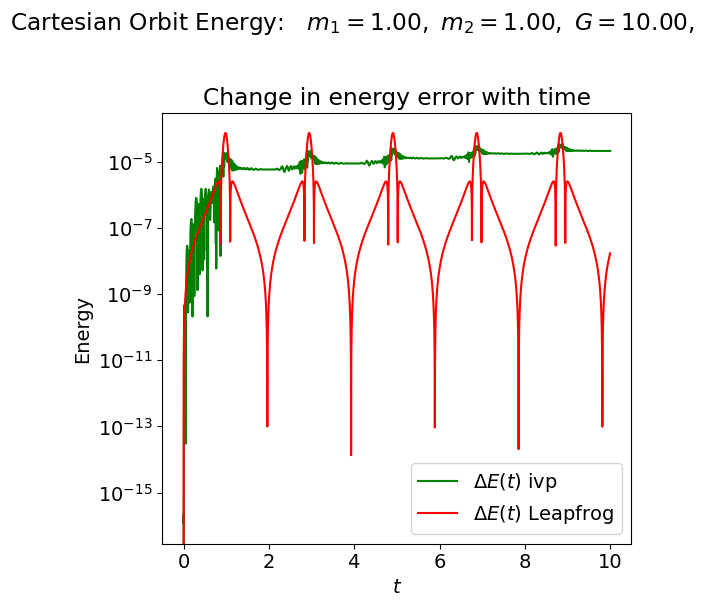

In [203]:
fig_5 = plt.figure(figsize=(6,6))

overall_title = 'Cartesian Orbit Energy:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$'
fig_5.suptitle(overall_title, va='baseline')


max_index = 10000
ax_5a = fig_5.add_subplot(1,1,1)
ax_5a.semilogy(t_pts[:max_index], E_tot_rel_pts[:max_index], 
               color='green', label=r'$\Delta E(t)$ ivp')
ax_5a.semilogy(t_pts[:max_index], E_tot_rel_pts_LF[:max_index], 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
#ax_5a.set_ylim(1.e-10, 1.e-2)    # (1.e-12, 5)
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy error with time')
ax_5a.legend()

fig_5.tight_layout()

We see that scipy's integrate.solve_ivp does not conserve energy, with the error in its solution quickly growing up to $10^{-5}$ before staying relatively constant. Leapfrog's solution, on the other hand, grows in error and then corrects itself back down to zero and repeating, doing a better job at conserving energy.

### Solving the $m_1 >> m_2$ orbit again

In [221]:
# Plotting time
t_start = 0.
t_end = 200.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters
m1 = 40.
m2 = 1.
G = 1000.

# Instantiate an orbit 
o4 = CartesianOrbitLeapfrog(m1 = m1, m2 = m2, G = G)

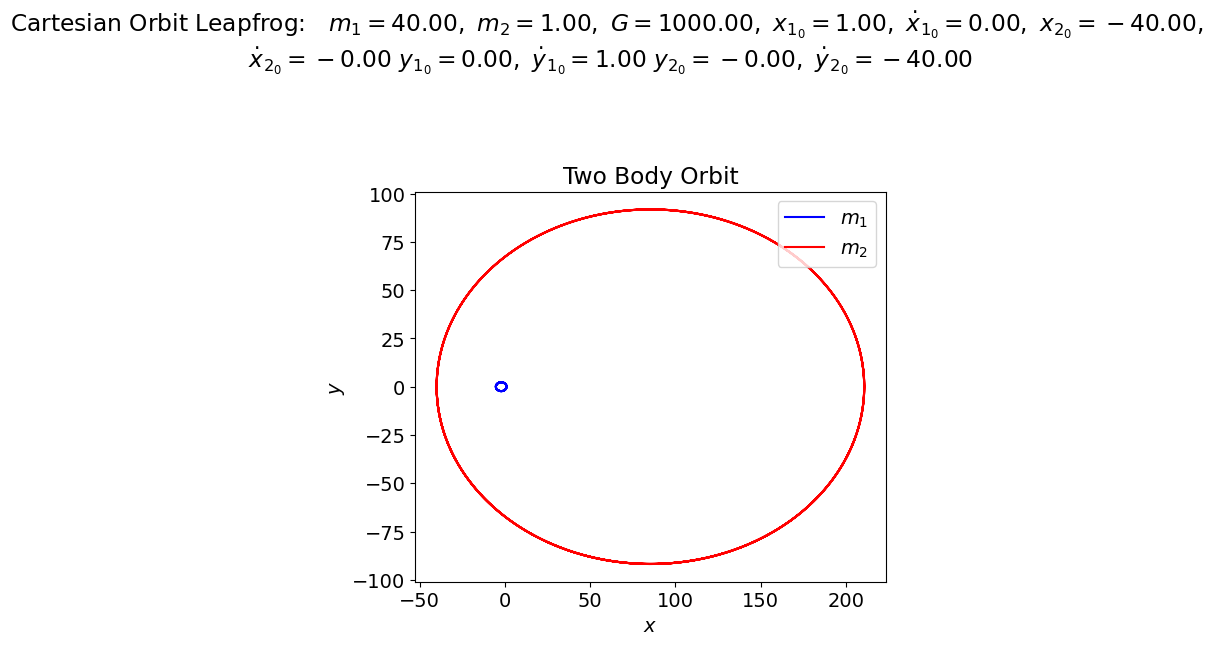

In [222]:
# initial conditions specified
x_1_0, x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0, z_1_0_dot = 0., 0.
z_2_0, z_2_0_dot = 0., 0.

# solve the orbit
(x_1_LF, x_2_LF, y_1_LF, y_2_LF, z_1_LF, z_2_LF,
 x_dot_1_LF, x_dot_2_LF, y_dot_1_LF,
 y_dot_2_LF, z_dot_1_LF, z_dot_2_LF) = o4.solve_ode_Leapfrog(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(6,6))
overall_title = 'Cartesian Orbit Leapfrog:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$' + \
                 rf' $x_{{1_0}} = {x_1_0:.2f},$' + \
                 rf' $\dot x_{{1_0}} = {x_dot_1_0:.2f},$' + \
                 rf' $x_{{2_0}} = {x_2_0:.2f},$' + '\n' + \
                 rf' $\dot x_{{2_0}} = {x_dot_2_0:.2f}$' + \
                 rf' $y_{{1_0}} = {y_1_0:.2f},$' + \
                 rf' $\dot y_{{1_0}} = {y_dot_1_0:.2f}$' + \
                 rf' $y_{{2_0}} = {y_2_0:.2f},$' + \
                 rf' $\dot y_{{2_0}} = {y_dot_2_0:.2f}$'
fig.suptitle(overall_title, va='baseline')
    
#plot from t=0 to t=200  
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 200.)    
plot_y_vs_x(x_1_LF[start : stop], y_1_LF[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='blue',
            label='$m_1$', 
            title=rf'', 
            ax=ax_a)
plot_y_vs_x(x_2_LF[start : stop], y_2_LF[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='red',
            label='$m_2$', 
            title=rf'Two Body Orbit',
            ax=ax_a)
ax_a.legend(loc = 'upper right')
fig.tight_layout()

### Energy Conservation ($m_1 >> m_2$)

In [187]:
# Plotting time

# In order for leapfrog to conserve energy, we must make
#  sure our delta t steps are sufficently small.
t_start = 0.
t_end = 1.
delta_t = 0.00001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Solving the orbits again to prevent issue with variable
# overloading

# Choosing parameters
m1 = 40.
m2 = 1.
G = 1000.

# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0, z_1_0_dot = 0., 0.
z_2_0, z_2_0_dot = 0., 0.

# solving the orbit with both methods
(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o2.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)
(x_1_LF, x_2_LF, y_1_LF, y_2_LF, z_1_LF, z_2_LF,
 x_dot_1_LF, x_dot_2_LF, y_dot_1_LF,
 y_dot_2_LF, z_dot_1_LF, z_dot_2_LF) = o4.solve_ode_Leapfrog(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

#comparing the energy of both soulutions at all times
E_tot_pts = o2.energy(t_pts, x_1, x_2, y_1, y_2,
                      z_1, z_2, x_dot_1, x_dot_2,
                      y_dot_1, y_dot_2, z_dot_1,
                      z_dot_2)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)


E_tot_pts_LF = o4.energy(t_pts, x_1_LF, x_2_LF, y_1_LF, y_2_LF,
                      z_1_LF, z_2_LF, x_dot_1_LF, x_dot_2_LF,
                      y_dot_1_LF, y_dot_2_LF, z_dot_1_LF,
                      z_dot_2_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

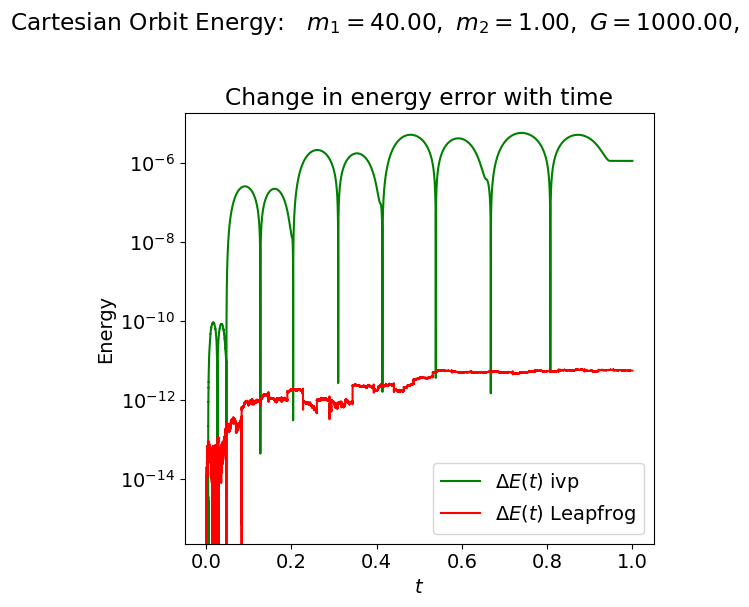

In [188]:
fig_5 = plt.figure(figsize=(6,6))

overall_title = 'Cartesian Orbit Energy:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$'
fig_5.suptitle(overall_title, va='baseline')

ax_5a = fig_5.add_subplot(1,1,1)
ax_5a.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ ivp')
ax_5a.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
#ax_5a.set_ylim(1.e-10, 1.e-2)    # (1.e-12, 5)
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy error with time')
ax_5a.legend()

fig_5.tight_layout()

It is hard to get $\Delta t$ low enough (while keeping runtimes reasonable)to see the energy conservation we saw in the equal mass case. While it doesn't conserve energy, solve_ivp is defintiely faster than Leapfrog for small $\Delta t$. For larger orbits, one should use solve_ivp if they don't want very long runtimes, as Leapfrog will not conserve energy anyway.